In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context("talk")

In [3]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

r = robjects.r

nsn = importr("NanoStringNorm")
egr = importr("edgeR")

py = pandas2ri.ri2py

In [4]:
cell_type = 'CD14'

# Read in RCC data

In [5]:
base_path = u'/home/gus/MEGAsync/zim/main/BCH/Projects/James/Nanostring_pipeline/OKT3/data/compare_ours_to_existing/cd14'

our_rcc_path = base_path+u"/ours"
thr_rcc_path = base_path+u"/theirs"

In [6]:
our_data = py(r(u"""read.markup.RCC(rcc.path="{PATH}")""".format(PATH=our_rcc_path)).rx2('x'))
thr_data = py(r(u"""read.markup.RCC(rcc.path="{PATH}")""".format(PATH=thr_rcc_path)).rx2('x'))

In [7]:
our_data.shape

(608, 9)

In [8]:
thr_data.shape

(540, 13)

In [9]:
our_data.head()

,CodeClass,Name,Accession,BWH006_CD14_w0_04,BWH008_CD14_w0_09,MGH001_CD14_w0_07,MGH002_CD14_w0_05,MGH004_CD14_w0_09,MGH007_CD14_w0_10
1,Endogenous,VTN,NM_000638.3,1,0,4,0,2,1
2,Endogenous,HLA-DQB1,NM_002123.3,8,8,2,11,0,2
3,Endogenous,KIT,NM_000222.2,2,0,3,1,3,2
4,Endogenous,LAG3,NM_002286.5,2,7,3,1,1,0
5,Endogenous,SOCS3,NM_003955.3,11,23,387,15,7,206


In [10]:
our_genes = set(our_data.Name.unique())
thr_genes = set(thr_data.Name.unique())

In [11]:
len(our_genes.intersection(thr_genes))

520

## Join tables by gene names

- We will only deal with the genes that are in commen between the tables from now on
- thats 520 including the pos/neg controls etc.

In [12]:
cmb_data = pd.merge(left=our_data, right=thr_data,
                    how='inner', on="Name",
                    left_on=None, right_on=None,
                    left_index=False, right_index=False,
                    sort=False, suffixes=('_OUR', '_THR'), copy=True, indicator=False)

cmb_data.index = cmb_data.Name.values
cmb_data = cmb_data.drop(labels=['Name'],axis=1)
cmb_data.head()

,CodeClass_OUR,Accession_OUR,BWH006_CD14_w0_04,BWH008_CD14_w0_09,MGH001_CD14_w0_07,MGH002_CD14_w0_05,MGH004_CD14_w0_09,MGH007_CD14_w0_10,CodeClass_THR,Accession_THR,GSM973583,GSM973584,GSM973585,GSM973586,GSM973587,GSM973588,GSM973589,GSM973590,GSM973591,GSM973592
VTN,Endogenous,NM_000638.3,1,0,4,0,2,1,Endogenous,NM_000638.3,20,44,36,27,22,23,9,22,27,20
HLA-DQB1,Endogenous,NM_002123.3,8,8,2,11,0,2,Endogenous,NM_002123.3,790,4686,4274,27,11,16,1778,2381,8212,2225
KIT,Endogenous,NM_000222.2,2,0,3,1,3,2,Endogenous,NM_000222.1,42,43,32,36,35,27,22,37,29,31
SOCS3,Endogenous,NM_003955.3,11,23,387,15,7,206,Endogenous,NM_003955.3,4265,8859,6741,5401,4226,2073,3250,6298,3883,4945
TCF7,Endogenous,NM_003202.2,0,1,3,1,0,1,Endogenous,NM_003202.2,44,81,59,138,38,44,30,58,62,33


In [13]:
code_class_missmatch = cmb_data.CodeClass_OUR != cmb_data.CodeClass_THR
sum(code_class_missmatch)

15

15 rows have CodeClass designations that don't match up...

In [14]:
cmb_data[code_class_missmatch][['CodeClass_OUR','CodeClass_THR']]

,CodeClass_OUR,CodeClass_THR
EEF1G,Housekeeping,Endogenous
TUBB,Housekeeping,Endogenous
TBP,Housekeeping,Endogenous
POLR2A,Housekeeping,Endogenous
GUSB,Housekeeping,Endogenous
HPRT1,Housekeeping,Endogenous
GAPDH,Housekeeping,Endogenous
SDHA,Housekeeping,Endogenous
OAZ1,Housekeeping,Endogenous
PPIA,Housekeeping,Endogenous


Looks like its not too big a deal.  They just added some genes as housekeepers.

## OK lets get rid of CodeClass and Accession Columns and write to file

In [15]:
cmb_data_extra_cols = cmb_data[['CodeClass_OUR','Accession_OUR','CodeClass_THR','Accession_THR']].copy()

cmb_data = cmb_data.drop(labels=['CodeClass_OUR','Accession_OUR','CodeClass_THR','Accession_THR'],axis=1)

In [16]:
print cmb_data.columns.values

['BWH006_CD14_w0_04' 'BWH008_CD14_w0_09' 'MGH001_CD14_w0_07'
 'MGH002_CD14_w0_05' 'MGH004_CD14_w0_09' 'MGH007_CD14_w0_10' 'GSM973583'
 'GSM973584' 'GSM973585' 'GSM973586' 'GSM973587' 'GSM973588' 'GSM973589'
 'GSM973590' 'GSM973591' 'GSM973592']


In [17]:
cmb_data_path = base_path+u"/combo_nanostring_data.csv"
cmb_data.to_csv(path_or_buf=cmb_data_path, 
           columns=None, header=True, index=True,)

## Write out the target table

In [18]:
targets = cmb_data.T.iloc[:,0:2].copy()
targets[u'source'] = targets.index.values
targets.source = targets.source.apply(lambda i: 'THEIRS' if i.startswith('GSM') else 'OURS' )
targets = pd.DataFrame(targets.source)
targets

,source
BWH006_CD14_w0_04,OURS
BWH008_CD14_w0_09,OURS
MGH001_CD14_w0_07,OURS
MGH002_CD14_w0_05,OURS
MGH004_CD14_w0_09,OURS
MGH007_CD14_w0_10,OURS
GSM973583,THEIRS
GSM973584,THEIRS
GSM973585,THEIRS
GSM973586,THEIRS


In [19]:
targets_path = base_path+u"/targets.csv"
targets.to_csv(path_or_buf=targets_path, 
           columns=None, header=True, index=True)

# EdgeR is used to perform normalization

In [20]:
x = py(r(u"""x <- read.delim("{PATH}", sep = ',', row.names=1) """.format(PATH=cmb_data_path)))

# Sort column names
x = py(r(u""" x <- x[,order(colnames(x))] """))

In [21]:
print r(u"head(x)")

         BWH006_CD14_w0_04 BWH008_CD14_w0_09 GSM973583 GSM973584 GSM973585
VTN                      1                 0        20        44        36
HLA-DQB1                 8                 8       790      4686      4274
KIT                      2                 0        42        43        32
SOCS3                   11                23      4265      8859      6741
TCF7                     0                 1        44        81        59
IKBKB                    5                 5       403       668       634
         GSM973586 GSM973587 GSM973588 GSM973589 GSM973590 GSM973591 GSM973592
VTN             27        22        23         9        22        27        20
HLA-DQB1        27        11        16      1778      2381      8212      2225
KIT             36        35        27        22        37        29        31
SOCS3         5401      4226      2073      3250      6298      3883      4945
TCF7           138        38        44        30        58        62        33
I

In [22]:
x.head()

,BWH006_CD14_w0_04,BWH008_CD14_w0_09,GSM973583,GSM973584,GSM973585,GSM973586,GSM973587,GSM973588,GSM973589,GSM973590,GSM973591,GSM973592,MGH001_CD14_w0_07,MGH002_CD14_w0_05,MGH004_CD14_w0_09,MGH007_CD14_w0_10
VTN,1,0,20,44,36,27,22,23,9,22,27,20,4,0,2,1
HLA-DQB1,8,8,790,4686,4274,27,11,16,1778,2381,8212,2225,2,11,0,2
KIT,2,0,42,43,32,36,35,27,22,37,29,31,3,1,3,2
SOCS3,11,23,4265,8859,6741,5401,4226,2073,3250,6298,3883,4945,387,15,7,206
TCF7,0,1,44,81,59,138,38,44,30,58,62,33,3,1,0,1


In [23]:
r("""# read in target annotations for the design matrix stuff later
targets <- read.table("{PATH}",sep = ',', header = TRUE, row.names = 1)
#targets <- targets[order(rownames(targets)),]
targets <- lapply(targets,factor)

# create the DEGList object
y <- DGEList(counts=x,group=targets$source)


# Filter for counts
#keep <- rowSums(y>30) >= 2
#y <- y[keep, , keep.lib.sizes=FALSE]

# TMM normalization factors
y <- calcNormFactors(y)
""".format(PATH=targets_path))

<ListVector - Python:0x7f4e83007680 / R:0x7f55f30>
[Matrix, DataFrame]
  counts: <class 'rpy2.robjects.vectors.Matrix'>
  <Matrix - Python:0x7f4e82f8a368 / R:0x7f6d120>
[       1,        8,        2, ...,       12,       66,       16]
<ListVector - Python:0x7f4e83007680 / R:0x7f55f30>
[Matrix, DataFrame]

In [24]:
n = py(r("n <- cpm(y)"))
n_rows = py(r("rownames(n)"))
n_cols = py(r("colnames(n)"))

In [25]:
y_norm = pd.DataFrame(n, columns=n_cols, index=n_rows)

In [26]:
y_norm.T

,VTN,HLA-DQB1,KIT,SOCS3,TCF7,IKBKB,ITGA6,CXCR4,NFKBIZ,MAPK14,...,HPRT1,GAPDH,SDHA,OAZ1,PPIA,G6PD,RPL19,POLR1B,ABCF1,ALAS1
BWH006_CD14_w0_04,82.417245,659.337962,164.834491,906.589698,0.000000,412.086226,82.417245,1318.675925,1071.424189,1153.841434,...,0.000000,8076.890039,164.834491,3956.027774,412.086226,329.668981,6016.458907,0.000000,494.503472,247.251736
BWH008_CD14_w0_09,0.000000,365.973097,0.000000,1052.172653,45.746637,228.733186,137.239911,914.932742,1235.159202,869.186105,...,503.213008,6953.488840,137.239911,3934.210791,228.733186,594.706282,9195.074058,45.746637,274.479823,274.479823
GSM973583,16.217750,640.601109,34.057274,3458.435099,35.679049,326.787654,38.922599,10269.079036,4452.583148,1630.694721,...,350.303391,7798.304887,377.873565,8541.077818,281.377955,968.199650,15899.881691,52.707686,525.455086,96.495610
GSM973584,22.348144,2380.077368,21.840232,4499.595691,41.140902,339.285464,25.903531,12075.616609,5085.726566,1689.824457,...,380.934278,8397.315222,380.934278,8284.050763,336.237989,883.259612,19958.416600,50.791237,536.863376,77.710593
GSM973585,17.891785,2124.152441,15.903809,3350.236687,29.322647,315.094209,26.340683,12230.028839,5401.828001,1684.809727,...,400.577180,9025.908393,445.306642,9821.098825,259.927872,1080.961993,19488.626498,79.022049,528.304643,88.464936
GSM973586,15.402530,15.402530,20.536706,3081.076401,78.724041,255.567900,39.932484,11833.136045,4929.379963,1287.537389,...,370.801641,6354.969654,406.170412,7532.407479,308.050594,966.936586,17311.872899,60.469191,628.651397,78.724041
GSM973587,26.836878,13.418439,42.695032,5155.120200,46.354607,564.794286,51.234039,8625.616407,5290.524446,1780.992781,...,308.624091,4479.318830,347.659550,2903.262205,296.425511,1124.709140,22086.750200,57.333329,763.631151,103.687936
GSM973588,31.527005,21.931830,37.009963,2841.542696,60.312532,378.324064,46.605138,12447.684138,3805.172466,1237.777643,...,357.762973,7129.215417,385.177760,6622.041854,376.953324,816.960659,17727.772157,52.088096,540.071308,76.761404
GSM973589,8.904809,1759.194485,21.767311,3215.625465,29.682697,281.985618,33.640389,13532.341379,5238.006526,1311.975190,...,374.991400,8189.455991,393.790442,8465.505070,336.403895,1002.285722,18032.238183,41.555775,593.653932,82.122127
GSM973590,10.494373,1135.777395,17.649628,3004.252850,27.666984,325.802588,17.172611,13825.859735,5801.003320,1410.539168,...,396.401099,7343.676188,383.521640,8141.248554,386.860759,989.333187,20398.199489,53.425900,641.110802,61.058172


In [27]:
cmb_cpm = pd.merge(left=targets, right=y_norm.T, 
                   how='inner', on=None, 
                   left_on=None, right_on=None, 
                   left_index=True, right_index=True, 
                   sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)

In [28]:
cmb_cpm_mean = cmb_cpm.groupby('source').mean()
cmb_cpm_mean = cmb_cpm_mean.T

/home/gus/anaconda2/envs/stack2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


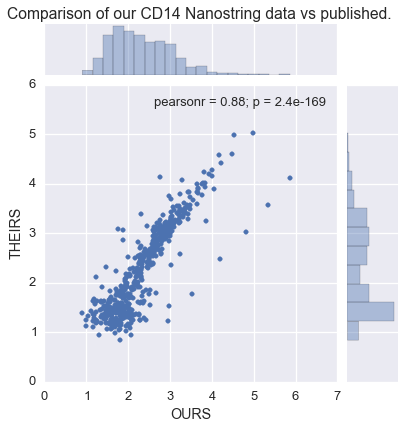

In [29]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean+1), kind='scatter',
             );

plt.suptitle("Comparison of our {cell} Nanostring data vs published.".format(cell=cell_type), y=1,);

### Lets look at the external controls

In [30]:
cmb_data_extra_cols.head()

,CodeClass_OUR,Accession_OUR,CodeClass_THR,Accession_THR
VTN,Endogenous,NM_000638.3,Endogenous,NM_000638.3
HLA-DQB1,Endogenous,NM_002123.3,Endogenous,NM_002123.3
KIT,Endogenous,NM_000222.2,Endogenous,NM_000222.1
SOCS3,Endogenous,NM_003955.3,Endogenous,NM_003955.3
TCF7,Endogenous,NM_003202.2,Endogenous,NM_003202.2


In [31]:
cmb_data_extra_cols.CodeClass_OUR.unique()

array(['Endogenous', 'Positive', 'Negative', 'Housekeeping'], dtype=object)

In [32]:
cmb_data_extra_cols.CodeClass_THR.unique()

array(['Endogenous', 'Positive', 'Negative'], dtype=object)

In [33]:
pos_ctrl = list(cmb_data_extra_cols.query(""" CodeClass_OUR == "Positive" """).index.values)
neg_ctrl = list(cmb_data_extra_cols.query(""" CodeClass_OUR == "Negative" """).index.values)
hsk_gene = list(cmb_data_extra_cols.query(""" CodeClass_OUR == "Housekeeping" """).index.values)
bth_ctrl = pos_ctrl + neg_ctrl
pan_gene = list(cmb_data_extra_cols[cmb_data_extra_cols.CodeClass_OUR.apply(lambda i: i in ['Housekeeping','Endogenous'])].index.values)

In [34]:
bth_ctrl

['POS_C(8)',
 'POS_A(128)',
 'POS_F(0.125)',
 'POS_D(2)',
 'POS_B(32)',
 'POS_E(0.5)',
 'NEG_C(0)',
 'NEG_D(0)',
 'NEG_E(0)',
 'NEG_A(0)',
 'NEG_H(0)',
 'NEG_G(0)',
 'NEG_F(0)',
 'NEG_B(0)']

In [35]:
cmb_cpm_mean.head()

source,OURS,THEIRS
VTN,27.268306,17.888145
HLA-DQB1,279.626299,1395.749960
KIT,54.113462,25.036577
SOCS3,1204.189985,3443.938653
TCF7,21.901164,40.591074


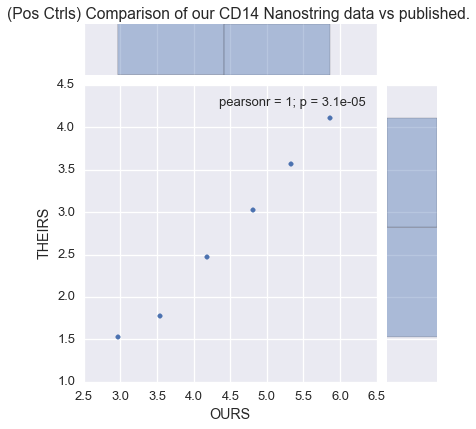

In [36]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean.loc[pos_ctrl]+1), kind='scatter',
             );

plt.suptitle("(Pos Ctrls) Comparison of our {cell} Nanostring data vs published.".format(cell=cell_type), y=1,);

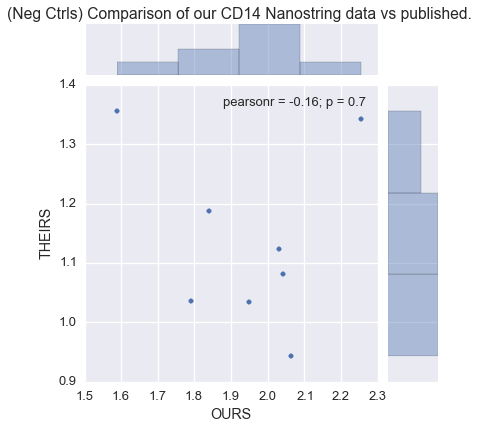

In [37]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean.loc[neg_ctrl]+1), kind='scatter',
             );

plt.suptitle("(Neg Ctrls) Comparison of our {cell} Nanostring data vs published.".format(cell=cell_type), y=1,);

In [38]:
cmb_cpm_mean.loc[neg_ctrl].head()

source,OURS,THEIRS
NEG_C(0),179.277108,20.998254
NEG_D(0),60.870736,9.856633
NEG_E(0),106.585016,12.274479
NEG_A(0),109.453229,11.059749
NEG_H(0),68.211021,14.408876


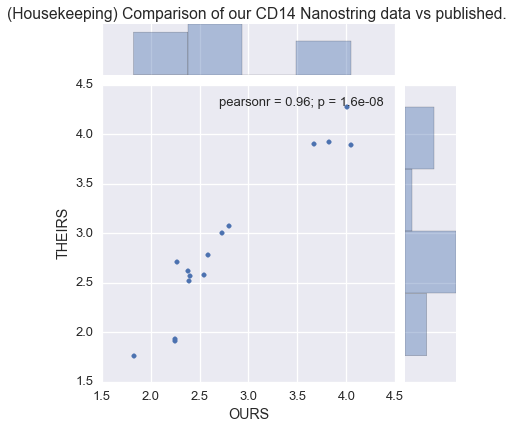

In [39]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean.loc[hsk_gene]+1), kind='scatter',
             );

plt.suptitle("(Housekeeping) Comparison of our {cell} Nanostring data vs published.".format(cell=cell_type), y=1,);

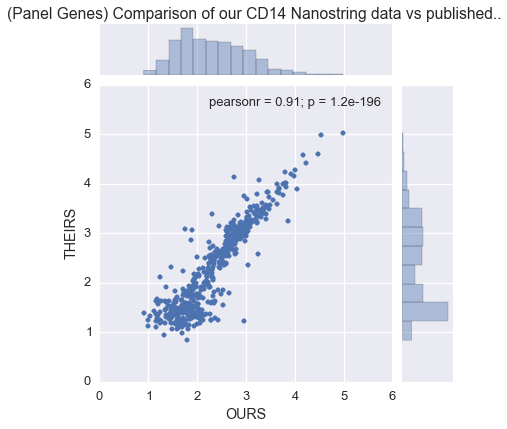

In [40]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean.loc[pan_gene]+1), kind='scatter',
             );

plt.suptitle("(Panel Genes) Comparison of our {cell} Nanostring data vs published..".format(cell=cell_type), y=1,);